In [1]:
from datetime import date
from enum import Enum

%load_ext google.cloud.bigquery
from google.cloud import bigquery


In [2]:
project = "celo-testnet"
client = bigquery.Client(project)
for dataset in client.list_datasets():
    print(dataset.dataset_id)

dataflow_metrics
load_test_data
segment_data
segment_data_events
segment_data_metrics
transaction_data
transaction_metrics_exporter


In [3]:
partition = date.today().strftime("%Y%m%d")
# partition = 20200316
# partition = "*"
dataset = "transaction_metrics_exporter"
table = "transaction_metrics_exporter_{0}".format(partition)
tme = client.get_dataset(dataset)
table_path = ".".join([project, dataset, table])
print(table_path)

celo-testnet.transaction_metrics_exporter.transaction_metrics_exporter_20200319


In [4]:
class EventTypes(Enum):
    RECEIVED_BLOCK="RECEIVED_BLOCK"
    RECEIVED_STATE="RECEIVED_STATE"
    RECEIVED_TRANSACTION="RECEIVED_TRANSACTION"
    RECEIVED_TRANSACTION_RECEIPT="RECEIVED_TRANSACTION_RECEIPT"
    RECEIVED_PARSED_TRANSACTION="RECEIVED_PARSED_TRANSACTION"
    RECEIVED_PARSED_LOG="RECEIVED_PARSED_LOG"

In [5]:
query_blocks = f"""
SELECT 
  MAX(T.timestamp) as timestamp,
  T.jsonPayload.number as blockNumber,
  MAX(T.jsonPayload.gasUsed) as gasUsed,
  MAX(T.jsonPayload.gasLimit) as gasLimit,
  COUNT(T.jsonPayload.transactions) as txAmount
FROM 
  `{table_path}` as T
WHERE
   T.jsonPayload.event='{EventTypes.RECEIVED_BLOCK.value}'
GROUP BY blockNumber
ORDER BY blockNumber DESC 
"""

df_blocks = client.query(
    query_blocks, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_blocks.describe()

,blockNumber,gasUsed,gasLimit,txAmount
count,1.071400e+04,1.071400e+04,10714.0,10714.000000
mean,1.138028e+06,6.755020e+04,20000000.0,1.778141
std,3.143106e+03,7.103836e+04,0.0,0.418650
min,1.132635e+06,0.000000e+00,20000000.0,1.000000
25%,1.135313e+06,0.000000e+00,20000000.0,2.000000
50%,1.137992e+06,5.872600e+04,20000000.0,2.000000
75%,1.140726e+06,9.979500e+04,20000000.0,2.000000
max,1.143550e+06,1.075162e+06,20000000.0,4.000000


In [6]:
df_blocks.head()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount
0,2020-03-19 17:39:15.108337+00:00,1143550.0,0.0,20000000.0,1
1,2020-03-19 17:38:59.476663+00:00,1143549.0,0.0,20000000.0,1
2,2020-03-19 17:38:54.673245+00:00,1143548.0,0.0,20000000.0,1
3,2020-03-19 17:38:54.154598+00:00,1143547.0,0.0,20000000.0,1
4,2020-03-19 17:38:38.587668+00:00,1143546.0,0.0,20000000.0,1


In [7]:
last_block, first_block = df_blocks.blockNumber.max(), df_blocks.blockNumber.min()
print(f"last block  : {last_block:.0f} on {df_blocks.timestamp.max()}") 
print(f"first block : {first_block:.0f} on {df_blocks.timestamp.min()}")
print(f"blocks load : {(last_block - first_block):.0f}")
print(f"transactions: {df_blocks.txAmount.sum()}")
print(f"mean gasUsed: {df_blocks.gasUsed.mean():.0f} GcWei")

last block  : 1143550 on 2020-03-19 17:39:15.108337+00:00
first block : 1132635 on 2020-03-19 00:00:01.518213+00:00
blocks load : 10915
transactions: 19051
mean gasUsed: 67550 GcWei


In [8]:
query_state = f"""
SELECT
  timestamp,
  jsonPayload.blockNumber,
  jsonPayload.contract,
  jsonPayload.function,
  jsonPayload.values.rewardsamount,
  jsonPayload.values.rewardsmultiplier,
  jsonPayload.values.medianRate,
  jsonPayload.values.currentStableBucket,
  jsonPayload.values.currentGoldBucket,
  jsonPayload.values.goldTokenTotalSupply
FROM 
  `{table_path}` as T
WHERE 
  jsonPayload.event='{EventTypes.RECEIVED_STATE.value}'
ORDER BY 
  T.jsonPayload.blockNumber DESC,
  T.timestamp DESC
"""

df_state = client.query(
    query_state, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_state.describe()

,blockNumber,rewardsamount,rewardsmultiplier,medianRate,goldTokenTotalSupply
count,5.695800e+04,3.241000e+03,3.242000e+03,3239.000000,3.244000e+03
mean,1.137415e+06,6.025405e+26,1.477616e+24,1.003224,2.228610e+26
std,2.820344e+03,2.594658e+21,1.275457e+20,0.000417,1.064570e+23
min,1.132635e+06,6.025376e+26,1.477305e+24,1.003000,2.227388e+26
25%,1.135008e+06,6.025387e+26,1.477588e+24,1.003000,2.227933e+26
50%,1.137381e+06,6.025397e+26,1.477653e+24,1.003000,2.228296e+26
75%,1.139754e+06,6.025411e+26,1.477697e+24,1.003000,2.228841e+26
max,1.143550e+06,6.025466e+26,1.477763e+24,1.004000,2.231200e+26


In [9]:
df_state.head()

,timestamp,blockNumber,contract,function,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply
0,2020-03-19 17:39:15.121689+00:00,1143550.0,EpochRewards,getRewardsMultiplier,NaN,1.477305e+24,NaN,None,None,NaN
1,2020-03-19 17:39:15.120006+00:00,1143550.0,SortedOracles,medianRate,NaN,NaN,1.004,None,None,NaN
2,2020-03-19 17:39:15.114937+00:00,1143550.0,EpochRewards,getTargetGoldTotalSupply,6.025466e+26,NaN,NaN,None,None,NaN
3,2020-03-19 17:39:15.110012+00:00,1143550.0,GoldToken,totalSupply,NaN,NaN,NaN,None,None,2.231200e+26
4,2020-03-19 17:39:15.105042+00:00,1143550.0,Exchange,getBuyAndSellBuckets,NaN,NaN,NaN,2.201640934675888882648513e+24,2.192869456848494903091307e+24,NaN


Text(0, 0.5, 'SortedOracles.medianRate')

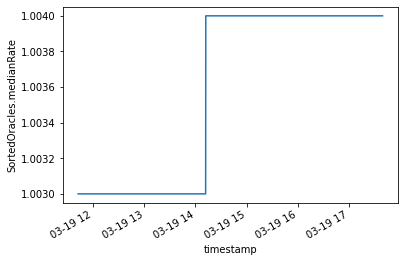

In [10]:
df_sortedOracles = df_state.set_index('timestamp')['medianRate'].dropna()
ax = df_sortedOracles.plot()
ax.set_ylabel("SortedOracles.medianRate")

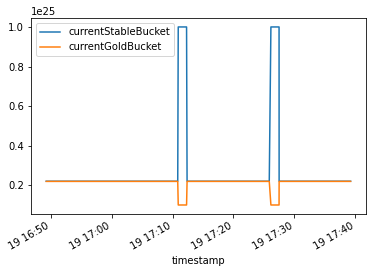

In [11]:
df_stableToken = df_state.set_index('timestamp')[['currentStableBucket', 'currentGoldBucket']].dropna().astype('float')
df_stableToken.plot()

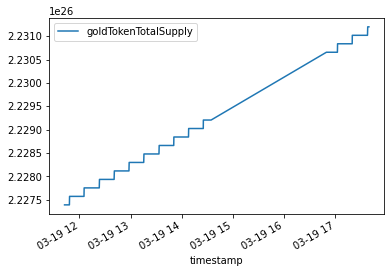

In [12]:
df_goldToken = df_state.set_index('timestamp')[['goldTokenTotalSupply']].dropna()
ax = df_goldToken.plot()

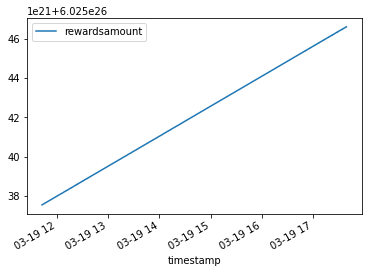

In [13]:
df_rewardsAmount = df_state.set_index('timestamp')[['rewardsamount']].dropna()
ax = df_rewardsAmount.plot()

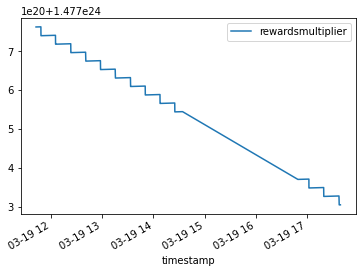

In [14]:
df_rewardsMultiplier = df_state.set_index('timestamp')[['rewardsmultiplier']].dropna()
ax = df_rewardsMultiplier.plot()